# Premier projet de Machine Learning : Prédiction du prix d'un Airbnb

## Chargement des librairies

Utiles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import warnings
warnings.filterwarnings("ignore")

Sklearn

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

## Téléchargement et informations sur les fichiers

### read_csv & head

In [84]:
test = pd.read_csv("airbnb_test.csv", engine='python')
train = pd.read_csv("airbnb_train.csv", engine='python')
prediction = pd.read_csv("prediction_example.csv", engine='python')

In [85]:
print(test.shape)
test.head(3)

(51877, 27)


,Unnamed: 0,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,14282777,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,...,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,11201,1.0,1.0
1,17029381,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,10019,3.0,3.0
2,7824740,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,...,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,10027,1.0,3.0


In [86]:
print(train.shape)
train.head(3)

(22234, 28)


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,5708593,4.317488,House,Private room,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",3,1.0,Real Bed,flexible,False,...,NaN,33.782712,-118.134410,Island style Spa Studio,Long Beach,0,NaN,90804,0.0,2.0
1,14483613,4.007333,House,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",4,2.0,Real Bed,strict,False,...,2017-09-17,40.705468,-73.909439,"Beautiful and Simple Room W/2 Beds, 25 Mins to...",Ridgewood,38,86.0,11385,1.0,2.0
2,10412649,7.090077,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",6,2.0,Real Bed,flexible,False,...,NaN,38.917537,-77.031651,2br/2ba luxury condo perfect for infant / toddler,U Street Corridor,0,NaN,20009,2.0,2.0


On comprend qu'il manque la colonne target (log_price) dans le fichier test. On doit donc déterminer et entrainer notre modèle avec le fichier train, pour faire la prédiction sur test.

In [87]:
prediction.head()

,Unnamed: 0,logpred
0,14282777,4.781464
1,17029381,4.781464
2,7824740,4.781464
3,19811650,4.781464
4,12410741,4.781464


prediction est un exemple du csv à rendre avec nos prédiction

### Informations sur les datasets :
- describe
- info
- na
- duplicated

Taille du dataset

In [88]:
print("Dimension du dataset train : ")
train.shape

Dimension du dataset train : 


(22234, 28)

Description du dataset

In [89]:
print("Quelques statistiques sur notre jeu de données :")
train.describe(include='object')

Quelques statistiques sur notre jeu de données :


,property_type,room_type,amenities,bed_type,cancellation_policy,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,name,neighbourhood,zipcode
count,22234,22234,22234,22234,22234,22234,22234,17509,22178,22178,16759,22178,22234,17518,22234,20148,21931
unique,31,3,21160,5,5,6,22169,2096,2,2,70,2852,2,1042,22155,558,674
top,Apartment,Entire home/apt,{},Real Bed,strict,NYC,Welcome to our unique shared space. This commu...,2017-01-01,t,t,100%,2015-03-30,f,2017-04-30,East Village Studio,Williamsburg,11211.0
freq,14635,12348,161,21622,9726,9739,3,88,22108,14953,13048,68,16401,420,4,878,425


On remarque déjà que toutes les colonnes n'ont pas le même nombre d'informations, nous feront face aux données manquantes plus tard.

Aussi, les colonnes amenities, description et name ont quasiement autant de valeurs uniques que de valeurs dans la colonnes, ces informations ne sont donc pas utiles pour notre modèle et allourdissent le dataset, ont les supprimera en premier lieu.

Informations du datasets (colonnes, taille, mémoire)

In [90]:
print("Apperçu des types de colonnes")
train.info()

Apperçu des types de colonnes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22234 non-null  int64  
 1   log_price               22234 non-null  float64
 2   property_type           22234 non-null  object 
 3   room_type               22234 non-null  object 
 4   amenities               22234 non-null  object 
 5   accommodates            22234 non-null  int64  
 6   bathrooms               22183 non-null  float64
 7   bed_type                22234 non-null  object 
 8   cancellation_policy     22234 non-null  object 
 9   cleaning_fee            22234 non-null  bool   
 10  city                    22234 non-null  object 
 11  description             22234 non-null  object 
 12  first_review            17509 non-null  object 
 13  host_has_profile_pic    22178 non-null  object 
 14  host_identity_verified  22178 non-null

## Preprocessing

### Supression logique de certaines colonnes

Comme décris ci-dessus, on supprime les colonnes donc le nombre de valeurs est égaler, ou presque égale, au nombre de lignes du dataset

In [91]:
first_drop = ["id", "amenities", "description", "name"]
train.drop(first_drop, axis = 1, inplace=True) 

### Traitement des valeurs nulles et duplicata

#### Traitement des valeurs nulles

In [92]:
col_na = train.isna().sum()[lambda x : x > 0] # Afficher les colonnes qui possèdent des valeurs nulles, et le nombre de NaN
print("Totale des valeurs nulles :")
col_na

Totale des valeurs nulles :


bathrooms                   51
first_review              4725
host_has_profile_pic        56
host_identity_verified      56
host_response_rate        5475
host_since                  56
last_review               4716
neighbourhood             2086
review_scores_rating      4978
zipcode                    303
bedrooms                    26
beds                        35
dtype: int64

In [93]:
b= round((col_na / train.shape[0]) * 100, 1) # Affichage par pourcentage
print(f"Pourcentage de cellules manquantes : \n{b[b>0]}" )

Pourcentage de cellules manquantes : 
bathrooms                  0.2
first_review              21.3
host_has_profile_pic       0.3
host_identity_verified     0.3
host_response_rate        24.6
host_since                 0.3
last_review               21.2
neighbourhood              9.4
review_scores_rating      22.4
zipcode                    1.4
bedrooms                   0.1
beds                       0.2
dtype: float64


Voici une illustration sur un graphique. Ne seront visibles que les NaN les plus fréquent, donc ceux impossible à remplacer.

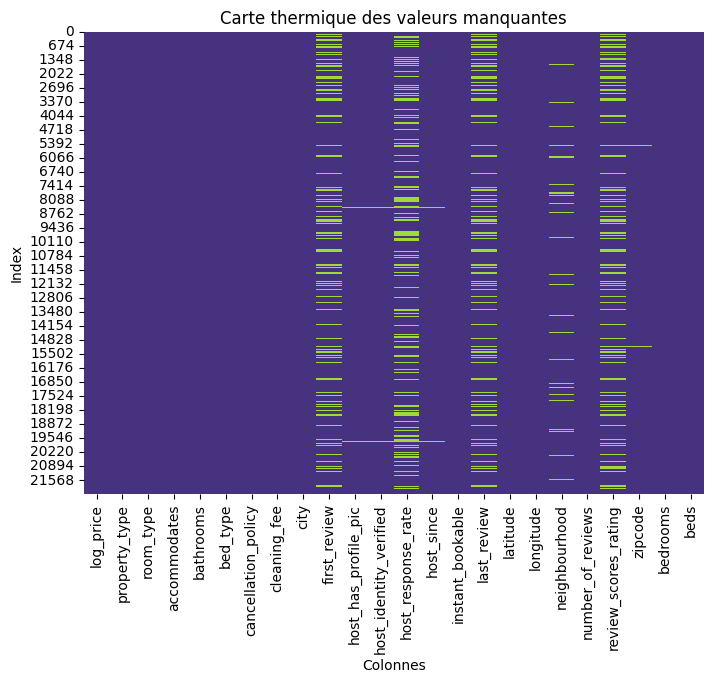

In [94]:
plt.figure(figsize=(8, 6))
sns.heatmap(train.isna(), cbar=False, cmap=sns.color_palette("viridis"))
plt.xlabel('Colonnes')
plt.ylabel('Index')
plt.title('Carte thermique des valeurs manquantes')
plt.show()

Arbitrairement on choisit de supprimer toutes les colonnes possédant plus de 15 % de la taille du dataset de NaN

In [95]:
seuil = train.shape[0] * 0.15
to_drop = col_na[col_na > seuil].index.to_list()
to_fill = col_na[col_na < seuil].index.to_list()
print(f"Colonnes à supprimer : {to_drop}\nColonnes à remplir : {to_fill}")

Colonnes à supprimer : ['first_review', 'host_response_rate', 'last_review', 'review_scores_rating']
Colonnes à remplir : ['bathrooms', 'host_has_profile_pic', 'host_identity_verified', 'host_since', 'neighbourhood', 'zipcode', 'bedrooms', 'beds']


Nous avons décider de traiter manuellement le remplissage des colonnes en utilisant les remplissages :
- par moyenne : .mean()
- par médiane : .median()
- par fréquence de la plus élevée : .mode[0]

In [110]:
def preprcessing(df: pd.DataFrame, to_drop : list) -> None:
    df['bathrooms'].fillna(df['bathrooms'].mean(), inplace=True) # sinon .mode[0]
    df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True) # sinon .mode[0]
    df['beds'].fillna(df['beds'].median(), inplace=True) # sinon .mode[0]
    df['host_has_profile_pic'].fillna(df['host_has_profile_pic'].mode()[0], inplace=True) # sinon aléatoire true false
    df['host_identity_verified'].fillna(df['host_identity_verified'].mode()[0], inplace=True) # sinon aléatoire true false
    df['neighbourhood'].fillna(df['neighbourhood'].mode()[0], inplace=True)

    # host since est une date donc on fait une conversion en nombre de jours et on rempli avec la médiane
    df['host_since'] = pd.to_datetime(df['host_since'])
    min_date = df['host_since'].min()
    df['host_since'] = (df['host_since'] - min_date).dt.days
    df['host_since'].fillna(df['host_since'].median(), inplace=True)

    # On regroupe les logements par quartier et on attribue un zipcode cohérent
    grouped_by_neighbourhood = df.groupby('neighbourhood')
    for neighbourhood, group in grouped_by_neighbourhood:
        if not group['zipcode'].isnull().all():
            mode_zipcode = group['zipcode'].mode()[0]  # Calcul du mode du code postal pour le quartier
            df.loc[group.index, 'zipcode'] = df.loc[group.index, 'zipcode'].fillna(mode_zipcode)

            modes_by_neighbourhood = {}
    for neighbourhood, group in grouped_by_neighbourhood:
        if not group['zipcode'].isnull().all():  # Vérifier si le groupe n'est pas vide
            mode_zipcode = group['zipcode'].mode()[0]  # Calcul du mode du code postal pour le quartier
            modes_by_neighbourhood[neighbourhood] = mode_zipcode
            
        last_null_neighbourhood = None
    for neighbourhood, group in grouped_by_neighbourhood:
        if group['zipcode'].isnull().any():  # Vérifier si le quartier a un code postal null
            last_null_neighbourhood = neighbourhood
            break

    if last_null_neighbourhood:
        random_zipcode = random.choice(list(modes_by_neighbourhood.values()))
        df.loc[grouped_by_neighbourhood.get_group(last_null_neighbourhood).index, 'zipcode'] = random_zipcode 

    df.drop(to_drop, axis=1, inplace=True)
    print("Nouvelles dimension de notre dataset :", df.shape)

In [97]:
preprcessing(train, to_drop)

Nouvelles dimension de notre dataset : (22234, 20)


#### Traitement des duplicatas

On vérifie s'il y a des lignes qui ont été entrées en double dans le dataset

In [98]:
nb_doublons = train.duplicated().sum()
print(f"Il y a {nb_doublons} doublons à supprimer")

Il y a 0 doublons à supprimer


### Sélection des colonnes corrélées à la target log_price

##### Présentation des types

Affichage de la répartition des types qui compose notre dataset


<AxesSubplot:title={'center':'Data types'}>

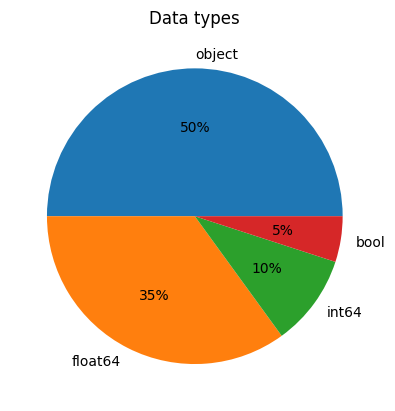

In [99]:
print("Affichage de la répartition des types qui compose notre dataset")
d=train.dtypes.value_counts()
d.plot(kind='pie', autopct='%1.0f%%', ylabel="", title="Data types")

Tableaux avec les colonnes selon les types

In [100]:
numeric_features = train.select_dtypes(include=['number']).columns.to_list()
categoric_features = train.select_dtypes(include=['object']).columns.to_list()
boolean_features = train.select_dtypes(include=['bool']).columns.tolist()

##### Selection des colonnes numériques finales avec la matrice de corrélation

<AxesSubplot:>

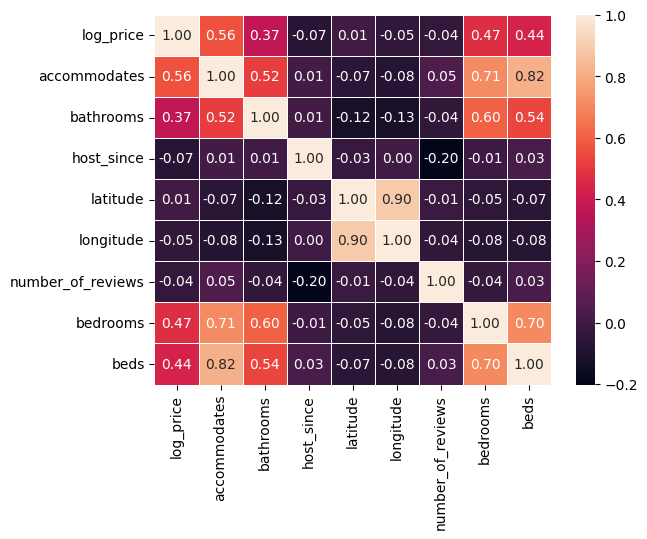

In [101]:
num_train = train[numeric_features]
sns.heatmap(num_train.corr(), annot=True, fmt=".2f", linewidths=.5)

On lit que host_since, longitude, latitude et number_of_reviews ne sont quasiment pas corrélées à notre target, on les supprime

In [102]:
numeric_features.remove("host_since")
numeric_features.remove("longitude")
numeric_features.remove("latitude")
numeric_features.remove("number_of_reviews")
numeric_features

['log_price', 'accommodates', 'bathrooms', 'bedrooms', 'beds']

##### Selection des colonnes cathégoriques finales

Pour ce faire, nous procédons à l'encodage des valeurs cathégoriques.

<AxesSubplot:>

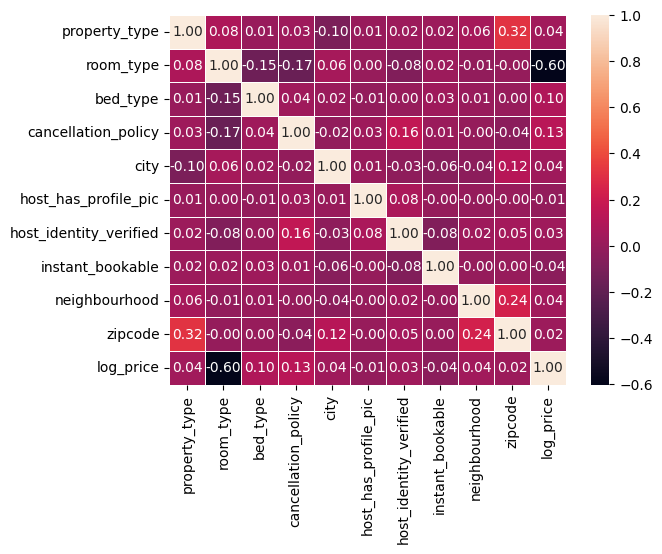

In [103]:
cat_train = train[categoric_features]
cat_train["log_price"] = train["log_price"]
for cols in categoric_features:
    col_to_scale = cat_train[cols].values.reshape(-1, 1)
    cat_train[cols] = OrdinalEncoder().fit_transform(col_to_scale) # On utilise OrdinalEncoder mais nous aurions pu en utiliser un autre comme OneHotEncoder ou LabelEncoder par exemple.
sns.heatmap(cat_train.corr(), annot=True, fmt=".2f", linewidths=.5)

Nous remarquons qu'il faut absolument supprimer room_type, host_has_profile_pic et instant_bookable qui ont des corrélations négatives avec log_price.
On remarque que bed_type et cancellation_policy sont les plus corrélées, il faut absolument les conserver.

In [104]:
categoric_features.remove("room_type")
categoric_features.remove("host_has_profile_pic")
categoric_features.remove("instant_bookable")
categoric_features

['property_type',
 'bed_type',
 'cancellation_policy',
 'city',
 'host_identity_verified',
 'neighbourhood',
 'zipcode']

##### Assemblage du dataset final

In [105]:
encoded_data = cat_train[categoric_features] # les données sont déjà scalées.

scaler1 = StandardScaler() # On utilise arbitrairement ce scaler mais nous aurions pu nous servir de MinMaxScaler par exemple.
num_bool_cols = numeric_features + boolean_features # On applique le StandardScaler aussi sur les variable de type bool

for cols in num_bool_cols:
    encoded_data[cols] = scaler1.fit_transform(train[cols].values.reshape(-1, 1))

print(f"Nouvelle dimension du dataset: {encoded_data.shape}")
encoded_data.head()

Nouvelle dimension du dataset: (22234, 13)


,property_type,bed_type,cancellation_policy,city,host_identity_verified,neighbourhood,zipcode,log_price,accommodates,bathrooms,bedrooms,beds,cleaning_fee
0,16.0,4.0,0.0,3.0,0.0,284.0,505.0,-0.648345,-0.072568,-0.403095,-1.483500,0.230941,-1.676831
1,16.0,4.0,2.0,4.0,1.0,410.0,250.0,-1.079870,0.393889,1.304671,-0.310272,0.230941,-1.676831
2,0.0,4.0,0.0,2.0,0.0,498.0,289.0,3.209212,1.326802,1.304671,0.862957,0.230941,-1.676831
3,16.0,4.0,0.0,4.0,1.0,472.0,156.0,-1.708725,-1.005481,-0.403095,-0.310272,-0.566378,0.596363
4,16.0,4.0,1.0,5.0,1.0,348.0,668.0,0.969970,0.393889,-0.403095,0.862957,0.230941,0.596363


## Détermination du modèle

### Recherche du modèle

On split le dataset en jeu d'entrainenemt, en séparant les données de la target

In [106]:
Y = encoded_data["log_price"]
X = encoded_data.drop("log_price", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

On définit deux dictionnaires pour les models et les paramètres. Pour tester toutes combinaisons et ressortir le modèle avec le meilleurs r²

In [65]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'BayesianRidge': BayesianRidge(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'LinearSVR': LinearSVR(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'MLPRegressor': MLPRegressor()
}

param_grid = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'alpha': [0.1, 1.0, 10.0]},
    'ElasticNet': {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]},
    'BayesianRidge': {},
    'RandomForestRegressor': {'n_estimators': [50, 100, 200]},
    'GradientBoostingRegressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'ExtraTreesRegressor': {'n_estimators': [50, 100, 200]},
    'AdaBoostRegressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'LinearSVR': {'C': [0.1, 1.0, 10.0]},
    'KNeighborsRegressor': {'n_neighbors': [5, 10, 15], 'weights': ['uniform', 'distance']},
    'MLPRegressor': {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.001, 0.01]}
}

On range les resultats dans de la validation croisée avec GridSearchCV, que l'on trie en fonction du r² score. In fine le modèle qui est le plus performant est en tête de liste.

In [66]:
results = []

for model_name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    results.append((model_name, grid_search.best_score_, grid_search.best_params_))

In [67]:
# Trie les résultats par r²
results.sort(key=lambda x: x[1], reverse=True)

print("Modèle:", results[0][0])
print("Variance expliquée:", results[0][1])
print("Meilleurs paramètres:", results[0][2])
print("\n")

Modèle: GradientBoostingRegressor
Variance expliquée: 0.602694334143536
Meilleurs paramètres: {'learning_rate': 0.2, 'n_estimators': 200}




In [68]:
model = GradientBoostingRegressor(learning_rate=0.2, n_estimators=200)

### Entrainement de notre modèle sur l'ensemble du jeu de données

In [69]:
model.fit(X, Y)

GradientBoostingRegressor(learning_rate=0.2, n_estimators=200)

## Prédiction du fichier test.csv

### Preprocessing

In [107]:
test = pd.read_csv("airbnb_test.csv", engine='python')

Nous réappliquon exactement le même preprocessing sur le jeu de données test.

In [108]:
seuil = test.shape[0] * 0.15
col_na = test.isna().sum()[lambda x : x > 0]
to_drop = col_na[col_na > seuil].index.to_list()
to_drop = to_drop + ["Unnamed: 0", "amenities", "description", "name"]

to_fill = col_na[col_na < seuil].index.to_list()
print(f"Colonnes à supprimer : {to_drop}\nColonnes à remplir : {to_fill}")

Colonnes à supprimer : ['first_review', 'host_response_rate', 'last_review', 'review_scores_rating', 'Unnamed: 0', 'amenities', 'description', 'name']
Colonnes à remplir : ['bathrooms', 'host_has_profile_pic', 'host_identity_verified', 'host_since', 'neighbourhood', 'zipcode', 'bedrooms', 'beds']


In [111]:
preprcessing(test, to_drop)

Nouvelles dimension de notre dataset : (51877, 19)


In [112]:
numeric_features2 = test.select_dtypes(include=['number']).columns.to_list()
categoric_features2 = test.select_dtypes(include=['object']).columns.to_list()
boolean_features2 = test.select_dtypes(include=['bool']).columns.tolist()

numeric_features2.remove("host_since")
numeric_features2.remove("longitude")
numeric_features2.remove("latitude")
numeric_features2.remove("number_of_reviews")

cat_test2 = test[categoric_features2]
for cols in categoric_features2:
    col_to_scale2 = cat_test2[cols].values.reshape(-1, 1)
    cat_test2[cols] = OrdinalEncoder().fit_transform(col_to_scale2)

categoric_features2.remove("room_type")
categoric_features2.remove("host_has_profile_pic")
categoric_features2.remove("instant_bookable")

encoded_data2 = cat_test2[categoric_features2] # les données sont déjà scalées.

num_bool_cols2 = numeric_features2 + boolean_features2 # colonnes sur lesquelles on applique le StandardScaler
for cols in num_bool_cols2:
    encoded_data2[cols] = StandardScaler().fit_transform(test[cols].values.reshape(-1, 1))


print(encoded_data2.shape)
encoded_data2.head()

(51877, 12)


,property_type,bed_type,cancellation_policy,city,host_identity_verified,neighbourhood,zipcode,accommodates,bathrooms,bedrooms,beds,cleaning_fee
0,0.0,4.0,2.0,4.0,1.0,76.0,180.0,-0.071817,-0.405473,-0.312317,-0.566064,0.604245
1,0.0,4.0,2.0,4.0,0.0,247.0,67.0,1.781974,-0.405473,2.036833,1.030071,0.604245
2,0.0,4.0,1.0,4.0,1.0,243.0,77.0,0.855078,-0.405473,-0.312317,1.030071,0.604245
3,17.0,4.0,0.0,5.0,1.0,318.0,709.0,0.391631,-0.405473,0.862258,0.232004,0.604245
4,0.0,4.0,1.0,2.0,1.0,118.0,318.0,-0.535265,-0.405473,-1.486893,-0.566064,0.604245
